Melakukan import libraries yang dibutukan

In [2]:
import pandas as pd
import tensorflow as tf
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import codecs
import numpy as np
factory=StemmerFactory()
stemmer=factory.create_stemmer()

Melakukan reading data hate speech tweet

In [ ]:
data=pd.read_csv('data/data.csv',encoding='latin-1')
stopword=pd.read_csv('data/stopwordbahasa.csv',header=None)
stopword=stopword.rename(columns={0:'stopwords'})
kamus_alay=pd.read_csv('data/new_kamusalay.csv',header=None,encoding='latin-1')
kamus_alay=kamus_alay.rename(columns={0:'asli',1:'baru'})
data

Menggunakan data HS dan Abusive

In [ ]:
data=data[['Tweet','HS','Abusive']]
data

Preprocessing Text

In [21]:
#Stemming text
def stemWord(x):
    return stemmer.stem(x)

In [22]:
#Lower text
def lowercase(text):
    return text.lower()

In [23]:
#Remove unnecessary charracters
def removeUnnecessary(text):
    text=re.sub('\n','',text) # menghapus newline
    text=re.sub('rt','',text) # menghapus kata retweet
    text=re.sub('user','',text) # menghapus kata user
    text=re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # menghapus url
    text = re.sub('  +', ' ', text) # menghapus karakter ekstra
    text=re.sub('x.{3} | x.{2}','',text) # menghapus pola emoji 
    return text

In [24]:
#Remove non alphanumeric character
def removeNonAlphanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    text="".join(filter(lambda x: not x.isdigit(), text))
    return text

In [25]:
#remove indonesian stopword
def removeStopWord(text):
    text = ' '.join(['' if word in stopword.stopwords.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text


In [26]:
#normalize alay
alay=dict(zip(kamus_alay['asli'],kamus_alay['baru']))
def normalizeAlay(text):
    return ' '.join([alay[word] if word in alay else word for word in text.split(' ')])

NameError: name 'kamus_alay' is not defined

In [30]:
def preProcessing(sentences):
    sentences=lowercase(sentences)
    sentences=removeNonAlphanumeric(sentences)
    sentences=removeUnnecessary(sentences)
    sentences=normalizeAlay(sentences)
    sentences=stemWord(sentences)
    sentences=removeStopWord(sentences)
    return sentences

In [ ]:
data['Tweet']=data['Tweet'].apply(preProcessing)
data

In [ ]:
data.to_csv('data_clean.csv',columns=['Tweet','HS','Abusive'],index=False)

Import Clean Data

In [3]:
data=pd.read_csv('data_clean.csv')
data.Tweet=data.Tweet.astype(str)
data

,Tweet,HS,Abusive
0,cowok usaha lacak perhati gue lantas remeh per...,1,1
1,telat tau edan sarap gue gaul cigax jifla cal ...,0,1
2,kadang pikir percaya tuhan jatuh kali kali kad...,0,0
3,ku tau mata sipit lihat,0,0
4,kaum cebong kafir lihat dongok dungu haha,1,1
...,...,...,...
13164,bicara ndasmu congor kate anjing,1,1
13165,kasur enak kunyuk,0,1
13166,hati hati bisu bosan huftxaa,0,0
13167,bom real mudah deteksi bom kubur dahsyat ledak...,0,0


Split Data Into Train, Validation and Test

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# Split data into train and validation
x_train,x_val,y_train,y_val=train_test_split(data['Tweet'],data['HS'],test_size=0.2,random_state=1)

#Split train data into train and test
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.25,random_state=1)

Tokenize the train,val and test data

In [6]:
vocab_size=1000
max_len=100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [7]:
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

In [8]:
sequences=tokenizer.texts_to_sequences(x_train)
padded=pad_sequences(sequences=sequences,padding=padding_type,truncating=trunc_type,maxlen=max_len)
sequences_val=tokenizer.texts_to_sequences(x_val)
padded_val=pad_sequences(sequences=sequences_val,padding=padding_type,truncating=trunc_type,maxlen=max_len)
sequences_test=tokenizer.texts_to_sequences(x_test)
padded_test=pad_sequences(sequences=sequences_test,padding=padding_type,truncating=trunc_type,maxlen=max_len)

Create the model architecture

In [25]:
model=tf.keras.models.Sequential([
        tf.keras.layers.Embedding(vocab_size, 64, input_length=max_len),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(16,activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 64)           64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 128)         66048     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 100, 128)          16512     
                                                                 
 dense_5 (Dense)             (None, 100, 16)           2064      
                                                                 
 dense_6 (Dense)             (None, 100, 1)            17        
                                                                 
Total params: 148,641
Trainable params: 148,641
Non-trainable params: 0
________________________________________________

Setting the loss function, optimizer and metrics for the model training

In [26]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

Train the model

In [27]:
history=model.fit(padded,y_train,epochs=20,validation_data=(padded_val,y_val))

Epoch 1/20
247/247 [==============================] - 10s 29ms/step - loss: 0.6144 - accuracy: 0.6780 - val_loss: 0.5604 - val_accuracy: 0.7541
Epoch 2/20
247/247 [==============================] - 7s 27ms/step - loss: 0.5060 - accuracy: 0.7906 - val_loss: 0.5358 - val_accuracy: 0.7758
Epoch 3/20
247/247 [==============================] - 6s 26ms/step - loss: 0.4727 - accuracy: 0.8133 - val_loss: 0.5026 - val_accuracy: 0.7914
Epoch 4/20
247/247 [==============================] - 6s 26ms/step - loss: 0.4930 - accuracy: 0.7621 - val_loss: 0.5731 - val_accuracy: 0.6892
Epoch 5/20
247/247 [==============================] - 7s 27ms/step - loss: 0.5231 - accuracy: 0.7243 - val_loss: 0.5340 - val_accuracy: 0.7549
Epoch 6/20
247/247 [==============================] - 7s 27ms/step - loss: 0.4559 - accuracy: 0.8168 - val_loss: 0.5059 - val_accuracy: 0.7808
Epoch 7/20
247/247 [==============================] - 6s 26ms/step - loss: 0.4259 - accuracy: 0.8398 - val_loss: 0.5254 - val_accuracy: 0.782

In [28]:
test_loss, test_acc = model.evaluate(padded_test,y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

83/83 [==============================] - 1s 13ms/step - loss: 0.5046 - accuracy: 0.8019
Test Loss: 0.5045685768127441
Test Accuracy: 0.8019283413887024


In [20]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

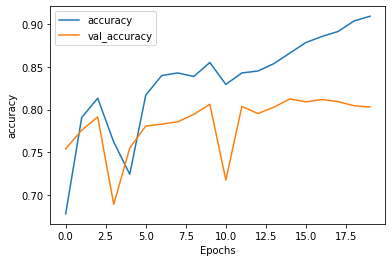

In [29]:
plot_graphs(history=history,metric='accuracy')

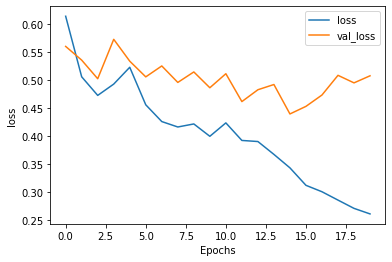

In [30]:
plot_graphs(history=history,metric='loss')

Entry with New Data with Bjorka Dataset

In [28]:
stopword=pd.read_csv('data/stopwordbahasa.csv',header=None)
stopword=stopword.rename(columns={0:'stopwords'})
kamus_alay=pd.read_csv('data/new_kamusalay.csv',header=None,encoding='latin-1')
kamus_alay=kamus_alay.rename(columns={0:'asli',1:'baru'})

In [18]:
bjorka=pd.read_excel('./Data/bjorka.xlsx')
bjorka

,Unnamed: 0,created at,username,text,sentimen
0,17688,2022-09-11,DraftAnakUnpad,- bjorka siapesi?,0
1,4373,2022-09-15,NephiLaxmus,- Sepertinya heker Bjorka mantan penyiar radio...,0
2,16018,2022-09-11,SuporterCampaig,""" Bjorka "" lagi trending bagi saya biasa aja, ...",0
3,17517,2022-09-11,uwiw14481104,""" Bjorka "" sebuah nama yang singkat namun memb...",0
4,7176,2022-09-14,AdPrabowoR1,""" Bjorka "" wajib ditangkap oleh Polri / Densus...",0
...,...,...,...,...,...
19995,17687,2022-09-11,Taula_,🥺 : hi lam knal. Km nak mna?\n😠 : ni cpa y? Dp...,0
19996,7475,2022-09-14,tweetieapril,🦋Rekomendasi Sendal Kiyowo🦋\na thread\n\n--\nt...,0
19997,6225,2022-09-14,alexandr1aa_,🧒🏻 Bapak km guru ya?\n👧🏻 Wahh kok tau?\n🧒🏻 Iya...,0
19998,19013,2022-09-11,jogjamnfs,🧔🏻: gesek pakai Line Bank bisa mbak?\n\n🧕🏽: ba...,0


In [19]:
del bjorka['created at']
del bjorka ['Unnamed: 0']
del bjorka ['username']
bjorka

,text,sentimen
0,- bjorka siapesi?,0
1,- Sepertinya heker Bjorka mantan penyiar radio...,0
2,""" Bjorka "" lagi trending bagi saya biasa aja, ...",0
3,""" Bjorka "" sebuah nama yang singkat namun memb...",0
4,""" Bjorka "" wajib ditangkap oleh Polri / Densus...",0
...,...,...
19995,🥺 : hi lam knal. Km nak mna?\n😠 : ni cpa y? Dp...,0
19996,🦋Rekomendasi Sendal Kiyowo🦋\na thread\n\n--\nt...,0
19997,🧒🏻 Bapak km guru ya?\n👧🏻 Wahh kok tau?\n🧒🏻 Iya...,0
19998,🧔🏻: gesek pakai Line Bank bisa mbak?\n\n🧕🏽: ba...,0


In [32]:
#normalize alay
alay=dict(zip(kamus_alay['asli'],kamus_alay['baru']))
def normalizeAlay(text):
    return ' '.join([alay[word] if word in alay else word for word in text.split(' ')])

In [33]:
bjorka['text']=bjorka['text'].apply(preProcessing)
bjorka

,text,sentimen
0,bjorka siapesi,0
1,pei heker bjorka mantan siar radio layan amkm ...,0
2,bjorka tren kemari pei orang individu pasuk po...,0
3,bjorka buah nama singkat indonesia government ...,0
4,bjorka wajib tangkap polisi republik indonesia...,0
...,...,...
19995,hi salam kenal km nak nih iya noq no bjorka,0
19996,rekomendasi sendal kiyowo a thread tag donghyu...,0
19997,km guru ya tau iya kemarin lini bjorka kena sp...,0
19998,gesek pakai line bank mbak bank kak line bank ...,0


In [34]:
bjorka.to_excel('./Data/bjorka_clean.xlsx')

In [47]:
bjorka=pd.read_excel('./Data/bjorka_clean.xlsx')
bjorka.text=bjorka.text.astype(str)

In [48]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [49]:
# Split data into train and validation
x_train,x_val,y_train,y_val=train_test_split(bjorka['text'],bjorka['sentimen'],test_size=0.2,random_state=1)

#Split train data into train and test
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.25,random_state=1)

In [50]:
vocab_size=1000
max_len=100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [51]:
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

In [52]:
sequences=tokenizer.texts_to_sequences(x_train)
padded=pad_sequences(sequences=sequences,padding=padding_type,truncating=trunc_type,maxlen=max_len)
sequences_val=tokenizer.texts_to_sequences(x_val)
padded_val=pad_sequences(sequences=sequences_val,padding=padding_type,truncating=trunc_type,maxlen=max_len)
sequences_test=tokenizer.texts_to_sequences(x_test)
padded_test=pad_sequences(sequences=sequences_test,padding=padding_type,truncating=trunc_type,maxlen=max_len)

In [53]:
model=tf.keras.models.Sequential([
        tf.keras.layers.Embedding(vocab_size, 64, input_length=max_len),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(16,activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           64000     
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 100, 128)          16512     
                                                                 
 dense_1 (Dense)             (None, 100, 16)           2064      
                                                                 
 dense_2 (Dense)             (None, 100, 1)            17        
                                                                 
Total params: 148,641
Trainable params: 148,641
Non-trainable params: 0
__________________________________________________

In [54]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [55]:
history=model.fit(padded,y_train,epochs=20,validation_data=(padded_val,y_val))

Epoch 1/20
375/375 [==============================] - 19s 25ms/step - loss: 0.3250 - accuracy: 0.9041 - val_loss: 0.3105 - val_accuracy: 0.9051
Epoch 2/20
375/375 [==============================] - 8s 23ms/step - loss: 0.2952 - accuracy: 0.9124 - val_loss: 0.3023 - val_accuracy: 0.9094
Epoch 3/20
375/375 [==============================] - 8s 22ms/step - loss: 0.2280 - accuracy: 0.9331 - val_loss: 0.2354 - val_accuracy: 0.9296
Epoch 4/20
375/375 [==============================] - 8s 22ms/step - loss: 0.2109 - accuracy: 0.9305 - val_loss: 0.2233 - val_accuracy: 0.9354
Epoch 5/20
375/375 [==============================] - 8s 22ms/step - loss: 0.2004 - accuracy: 0.9420 - val_loss: 0.2240 - val_accuracy: 0.9349
Epoch 6/20
375/375 [==============================] - 8s 22ms/step - loss: 0.2168 - accuracy: 0.9204 - val_loss: 0.2228 - val_accuracy: 0.9332
Epoch 7/20
375/375 [==============================] - 8s 22ms/step - loss: 0.1880 - accuracy: 0.9409 - val_loss: 0.2119 - val_accuracy: 0.934

In [56]:
test_loss, test_acc = model.evaluate(padded_test,y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

125/125 [==============================] - 1s 10ms/step - loss: 0.2580 - accuracy: 0.9213
Test Loss: 0.2580266296863556
Test Accuracy: 0.9213348627090454


In [57]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

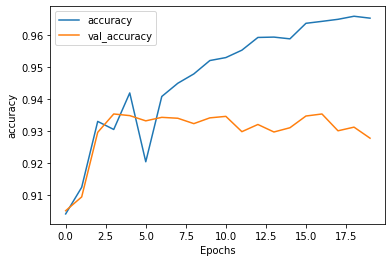

In [58]:
plot_graphs(history=history,metric='accuracy')

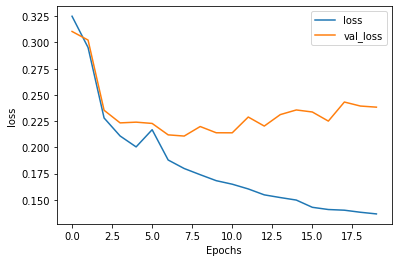

In [59]:
plot_graphs(history=history,metric='loss')